In [5]:
import os
%matplotlib inline
%matplotlib notebook
from CheXpert2 import names
import cv2
from CheXpert2.dataloaders.CXRLoader import CXRLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [6]:
img_dir="/mnt/c/Users/bejo2361/PycharmProjects/IA-MED_IMG"
dataset = CXRLoader(
            split="Train",
            img_dir=img_dir,
            img_size=224,
            prob=[0,1,0,1,0,0],
            intensity=0,
            label_smoothing=0,
            channels=1,
            use_frontal=False,
            datasets=["ChexPert"]
        )
i=0

/mnt/c/Users/bejo2361/PycharmProjects/IA-MED_IMG/CheXpert2/dataloaders/CXRLoader.py:179: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=data.groupby("Exam ID").mean().round(0)


torch.Size([2, 224, 224])
228
220


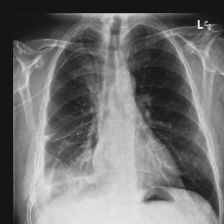

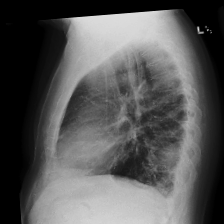

In [30]:
images,label,idx = dataset[i]
print(images.shape)
frontal,lateral =   images[0,:,:].numpy().astype(np.uint8),images[1,:,:].numpy().astype(np.uint8)
#frontal,lateral = cv2.cvtColor(frontal[:,:,None],cv2.COLOR_GRAY2RGB),cv2.cvtColor(lateral[:,:,None],cv2.COLOR_GRAY2RGB)
print(np.max(frontal))
print(np.max(lateral))
frontal_image = Image.fromarray(frontal)
lateral_image = Image.fromarray(lateral)
frontal_image.show()
lateral_image.show()
i+=1

In [8]:
# import albumentations as A
# transform = A.Compose(
#     A.augmentations.HorizontalFlip(p=1)
# )
# frontal2=transform(image=frontal)["image"]
# frontal_image = Image.fromarray(frontal2)
# frontal_image.show()